# Circuit Knitting Toolbox Tutorial
----------------------------------------

### Outline:

 * background, motivation and goals
 * quantum middleware and the circuit knitting toolbox
 * circuit cutting explanation
 * circuit cutting demo
 * entanglement forging explanation
 * entanglement forging demo

## Background, motivation and goals
#### Background and motivation
One major challenge of near-term quantum computation is the limited number of qubits. Circuit knitting techniques allow us to partition large quantum circuits into subcircuits that fit on smaller devices, incorporating classical simulation to "knit" together the results to achieve the target answer.

The circuit knitting toolbox gives us the opportunity to put these tools in users' hands quickly, gather useful feedback on the techniques and software implementations, and ultimately inform how we integrate the methods into the quantum software stack.

#### Goals
   * Provide the latest circuit knitting software tools to the community
   * Provide an example for how model developers might leverage quantum serverless in their own workflows
   * Gain a better understanding of how the community will use these tools and how the software implementation might be improved to cater to these use cases

## Quantum middleware and the Circuit Knitting Toolbox
 1. Users can implement hybrid workflows and seamlessly orchestrate the various compute resources with `Quantum Serverless`
 2. The user may use Qiskit nested programs to generate and optimize circuits
 3. The user may use the `Circuit Knitting Toolbox` to decompose large circuits into many smaller circuits
 4. Users may then send the smaller circuits to the QPUs via Runtime primitives
 5. Finally, the large circuit is reconstructed classically, using the results from the quantum experiments
 
 
![title](middleware_for_quantum.png)

## Circuit cutting overview

Circuit cutting is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use an automatic method to find optimal cut(s). See [tutorial 2](tutorial_2_manual_cutting.ipynb) to manually cut a circuit.
2. **Evaluate**: Execute those subcircuits on quantum backend(s).
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

## Demo: Circuit cutting with automatic cut finding

### Create a quantum circuit with Qiskit

In this case, we'll create a hardware-efficient circuit (`EfficientSU2` from the Qiskit circuit library) with two (linear) entangling layers.

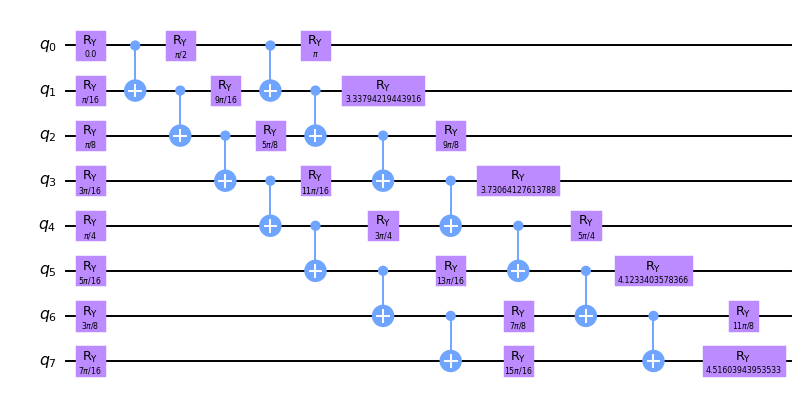

In [26]:
import numpy as np
from qiskit.circuit.library import EfficientSU2

num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit = circuit.bind_parameters(params)
circuit.draw("mpl", fold=-1, scale=0.7)

## Decompose the circuit with wire cutting

In this example, we will use an automatic method to find cuts matching our criteria. See [tutorial 2](tutorial_2_manual_cutting.ipynb) for how to manually cut a circuit.

   * `method='automatic'`: Use a mixed integer programming (MIP) model to find optimal cut(s)
   * `max_subcircuit_width=6`: Only allow subcircuits with 6 qubits or less
   * `max_cuts=2`: Cut the circuit no more than two times
   * `num_subcircuits=[2]`: A list of the number of subcircuits to try, in this case 2 subcircuits

In [27]:
%%capture

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

cuts = cut_circuit_wires(
    circuit=circuit,
    method="automatic",
    max_subcircuit_width=5,
    max_cuts=2,
    num_subcircuits=[2],
)

**The results from decompose includes information about the wire cutting process, e.g.,**

- `subcircuits`: list of `QuantumCircuit` objects for the subcircuits
- `complete_path_map`: a dictionary mapping indices of qubits in original circuit to their indices in the subcircuits. Note that some qubit indices may be mapped to more than one subcircuit.
- `num_cuts`: the number of times the circuit was cut
- `classical_cost`: the final value of the objective function used to find optimal cut(s). The objective function represents the postprocessing cost to reconstruct the original circuit output and is set to be the number of floating-point multiplications involved in the reconstruction. This quantity is also returned in the case of [manual wire cutting](tutorial_2_manual_cutting.ipynb). See [Section 4.1.4 of CutQC](https://doi.org/10.1145/3445814.3446758).

In [28]:
print(cuts.keys())

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])


**The two subcircuits produced:**

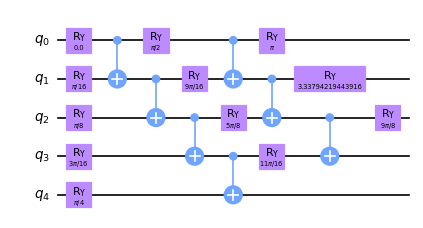

In [29]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

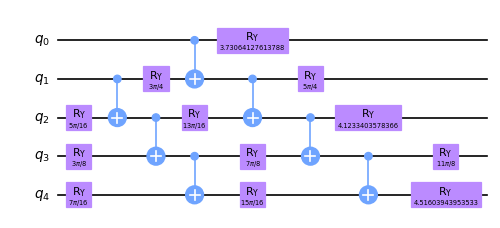

In [30]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)

## Evaluate the subcircuits

**Set up the Qiskit Runtime Service**

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.
Alternatively, if a Qiskit Runtime Service is not passed, then a local statevector simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html).

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime Service.
# service = QiskitRuntimeService()

**Configure the Qiskit Runtime Primitive**

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Qiskit Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems). In this tutorial, two local cores will be used to support each of the parallel backend threads we'll specify below.

If no service was set up, the `backend_names` argument will be ignored, and Qiskit Primitives will be used with statevector simulator.

In [32]:
from qiskit_ibm_runtime import Options

# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

**Evaluate the subcircuits on the backend(s)**

In [33]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import evaluate_subcircuits

# Estimates for the quasi-probability distribution for each subcircuit
subcircuit_instance_probabilities = evaluate_subcircuits(
    cuts,
    service=service,
    #backend_names=backend_names,
    options=options,
)

## Reconstruct the full circuit output

Next, the results of the subcircuit experiments are classically postprocessed to reconstruct the original circuit's full probability distribution.

In [34]:
%%capture

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import (
    reconstruct_full_distribution,
)

reconstructed_probabilities = reconstruct_full_distribution(
    circuit, subcircuit_instance_probabilities, cuts
)

**Here are the reconstructed probabilities for the original 8-qubit circuit:**

In [35]:
print(
    "Size of reconstructed probability distribution: ", len(reconstructed_probabilities)
)

Size of reconstructed probability distribution:  256


## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [36]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify

metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)

**The verify step includes several metrics**

For example, the chi square loss is computed. Since we're using the Qiskit Sampler with statevector simulator, we expect the reconstructed distributed to exactly match the ground truth. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting_toolbox/utils/metrics.py).

In [37]:
metrics

{'nearest': {'chi2': 0,
  'Mean Squared Error': 1.126087283605198e-34,
  'Mean Absolute Percentage Error': 5.09533319244702e-10,
  'Cross Entropy': 3.56455111606822,
  'HOP': 0.9945381353717201},
 'naive': {'chi2': 0,
  'Mean Squared Error': 1.671367489718917e-34,
  'Mean Absolute Percentage Error': 5.095341312501459e-10,
  'Cross Entropy': 3.56455111606822,
  'HOP': 0.9945381353717199}}

**Visualize both distributions**

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

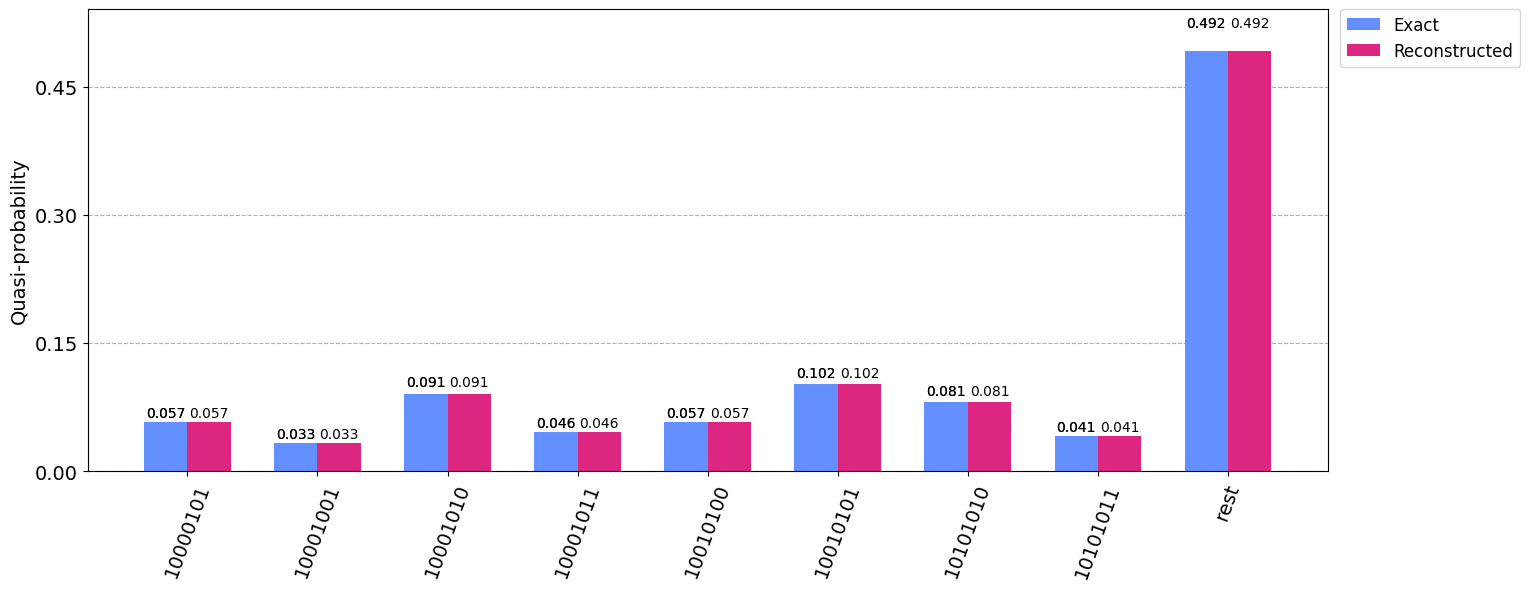

In [54]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

## Demo: Circuit cutting with quantum serverless

[**Quantum Serverless**](https://github.com/Qiskit-Extensions/quantum-serverless) is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to configure a circuit cutting workflow and seamlessly adapt each step to run on a different remote backend.


![title](cutting_with_serverless.png)

### We will use the same, 8-qubit circuit from before

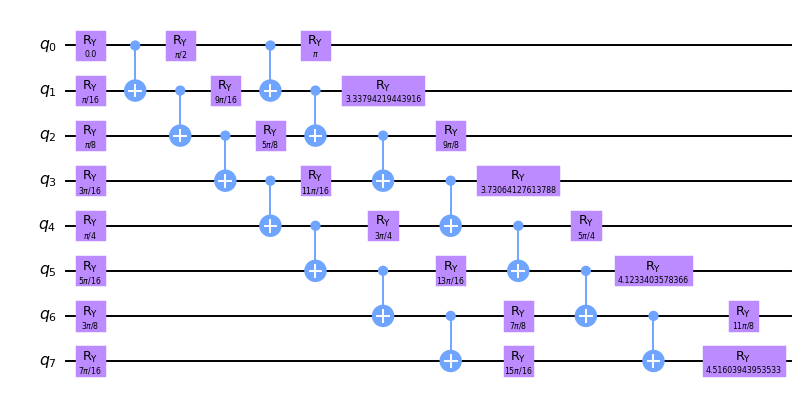

In [39]:
circuit.draw("mpl", fold=-1, scale=0.7)

## Set up Quantum Serverless

We can use Quantum Serverless to allocate the steps of wire cutting to various compute resources. For this tutorial, we will use our local CPU cores as our cluster. See the [Quantum Serverless](https://github.com/Qiskit-Extensions/quantum-serverless) documentation (and below) for more informatin about how to use other clusters.

In [40]:
from quantum_serverless import QuantumServerless, get

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

## Decompose the circuit with wire cutting 

### Use `quantum-serverless` to send the `cut_circuit_wires` method to a remote cluster

Here we create a wrapper function for the `cut_circuit_wires` function and annotate it with the `@run_qiskit_remote()` decorator from `quantum-serverless`. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [41]:
from typing import Optional, Sequence, Dict, Any
from qiskit import QuantumCircuit
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
from quantum_serverless import run_qiskit_remote, get

# Create a wrapper function to be sent to remote cluster
@run_qiskit_remote()
def cut_circuit_wires_remote(
    circuit: QuantumCircuit,
    method: str,
    subcircuit_vertices: Optional[Sequence[Sequence[int]]] = None,
    max_subcircuit_width: Optional[int] = None,
    max_subcircuit_cuts: Optional[int] = None,
    max_subcircuit_size: Optional[int] = None,
    max_cuts: Optional[int] = None,
    num_subcircuits: Optional[Sequence[int]] = None,
) -> Dict[str, Any]:
    return cut_circuit_wires(
        circuit=circuit,
        method=method,
        subcircuit_vertices=subcircuit_vertices,
        max_subcircuit_width=max_subcircuit_width,
        max_subcircuit_cuts=max_subcircuit_cuts,
        max_subcircuit_size=max_subcircuit_size,
        max_cuts=max_cuts,
        num_subcircuits=num_subcircuits,
    )

### Decompose the circuit in a serverless context
   
We will call the `cut_circuit_wires_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function from `quantum-serverless` is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [42]:
%%capture

# serverless.set_provider("azure")
with serverless:
    cuts_future = cut_circuit_wires_remote(
        circuit=circuit,
        method="automatic",
        max_subcircuit_width=5,
        max_cuts=2,
        num_subcircuits=[2],
    )
    cuts = get(cuts_future)

### The two subcircuits produced

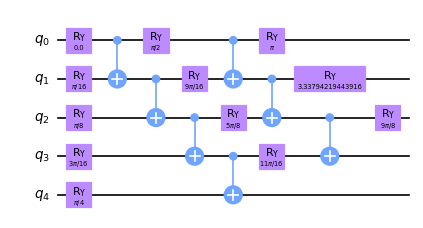

In [43]:
# visualize the first subcircuit
cuts["subcircuits"][0].draw("mpl", fold=-1, scale=0.6)

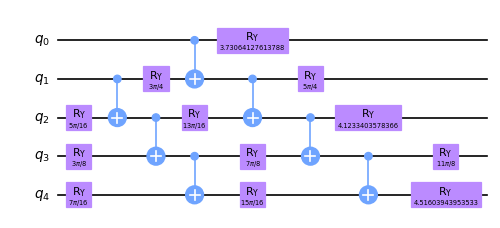

In [44]:
# visualize the second subcircuit
cuts["subcircuits"][1].draw("mpl", fold=-1, scale=0.6)

## Evaluate the subcircuits

### Use `quantum-serverless` to send the `evaluate_subcircuits` method to a remote cluster

Here we create a wrapper function for the `evaluate_subcircuits` function and annotate it with the `@run_qiskit_remote()` decorator from `quantum-serverless`. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [45]:
from nptyping import NDArray
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import evaluate_subcircuits

# Create a wrapper function to be sent to remote cluster
@run_qiskit_remote()
def evaluate_subcircuits_remote(
    cuts: Dict[str, Any],
    service_args: Optional[Dict[str, Any]] = None,
    backend_names: Optional[Sequence[str]] = None,
    options_dict: Optional[Dict] = None,
) -> Dict[int, Dict[int, NDArray]]:
    service = None if service_args is None else QiskitRuntimeService(**service_args)
    options = None if options_dict is None else Options(**options_dict)

    return evaluate_subcircuits(
        cuts, service=service, backend_names=backend_names, options=options
    )

### Set up the Qiskit Runtime Service

In [47]:
# Use local versions of the primitives by default.
service = None

# Uncomment the following line to instead use Qiskit Runtime.
# service = QiskitRuntimeService()

### Configure the Qiskit Runtime Primitive

In [48]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

### Evaluate the subcircuits on the quantum backend(s)

We will call the `evaluate_subcircuits_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, our local CPU is the default cluster for this demo. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

In [49]:
from dataclasses import asdict

# serverless.set_provider("ibm")
with serverless:
    # QiskitRuntimeService is not serializable, so we must convert it to a dictionary before passing to remote function
    service_args = None if service is None else service.active_account()

    # The Options class is not serializable, so we must convert it to a dictionary before passing to remote function
    options_dict = asdict(options)

    subcircuit_probabilities_future = evaluate_subcircuits_remote(
        cuts,
        service_args=service_args,
#         backend_names=backend_names,
        options_dict=options_dict,
    )
    subcircuit_instance_probabilities = get(subcircuit_probabilities_future)

## Reconstruct the full circuit output

### Use `quantum-serverless` to send the `reconstruct_full_distribution` method to a remote cluster

Next, the results of the subcircuit experiments are classically postprocessed to reconstruct the original circuit's full probability distribution.

Here, we create a wrapper function for the `reconstruct_full_distribution` function and annotate it with the `@run_qiskit_remote()` decorator from `quantum-serverless`. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [50]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import (
    reconstruct_full_distribution,
)

@run_qiskit_remote(target={"cpu": 8})
def reconstruct_full_distribution_remote(
    circuit: QuantumCircuit,
    subcircuit_instance_probabilities: Dict[int, Dict[int, NDArray]],
    cuts: Dict[str, Any],
    num_threads: int = 1,
) -> NDArray:
    return reconstruct_full_distribution(
        circuit, subcircuit_instance_probabilities, cuts
    )

### Reconstruct the output

We will call the `reconstruct_full_distribution_remote` function within a `QuantumServerless` context, which means it will be run on the specified cluster. Remember, our local CPU is the default cluster for this demo. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

In [25]:
# serverless.set_provider("aws")
with serverless:
    reconstructed_probabilities_future = reconstruct_full_distribution_remote(
        circuit, subcircuit_instance_probabilities, cuts, num_threads=8
    )
    reconstructed_probabilities = get(reconstructed_probabilities_future)

(reconstruct_full_distribution_remote pid=18749) Exception ignored in atexit callback: <function shutdown at 0x10d9904c0>
(reconstruct_full_distribution_remote pid=18749) Traceback (most recent call last):
(reconstruct_full_distribution_remote pid=18749)   File "/usr/local/Cellar/python@3.10/3.10.6_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/logging/__init__.py", line 2182, in shutdown
(reconstruct_full_distribution_remote pid=18749)     h.flush()
(reconstruct_full_distribution_remote pid=18749)   File "/usr/local/Cellar/python@3.10/3.10.6_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/logging/__init__.py", line 1086, in flush
(reconstruct_full_distribution_remote pid=18749)     self.release()
(reconstruct_full_distribution_remote pid=18749)   File "/Users/caleb/projects/repos_public_acct/circuit-knitting-toolbox/ckt/lib/python3.10/site-packages/ray/_private/worker.py", line 1618, in sigterm_handler
(reconstruct_full_distribution_remote pid=18749)     sys.exi

## Verify the results

In [26]:
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import verify

metrics, exact_probabilities = verify(circuit, reconstructed_probabilities)
metrics

{'nearest': {'chi2': 0.01607280934423852,
  'Mean Squared Error': 4.880833194092035e-07,
  'Mean Absolute Percentage Error': 193027.1979099796,
  'Cross Entropy': 3.6650708722358343,
  'HOP': 0.9917264171080507},
 'naive': {'chi2': 0.015410143642339478,
  'Mean Squared Error': 5.082338224677203e-07,
  'Mean Absolute Percentage Error': 194722.40276111296,
  'Cross Entropy': 3.644553585729721,
  'HOP': 0.9896913544533187}}

### Visualize both distributions


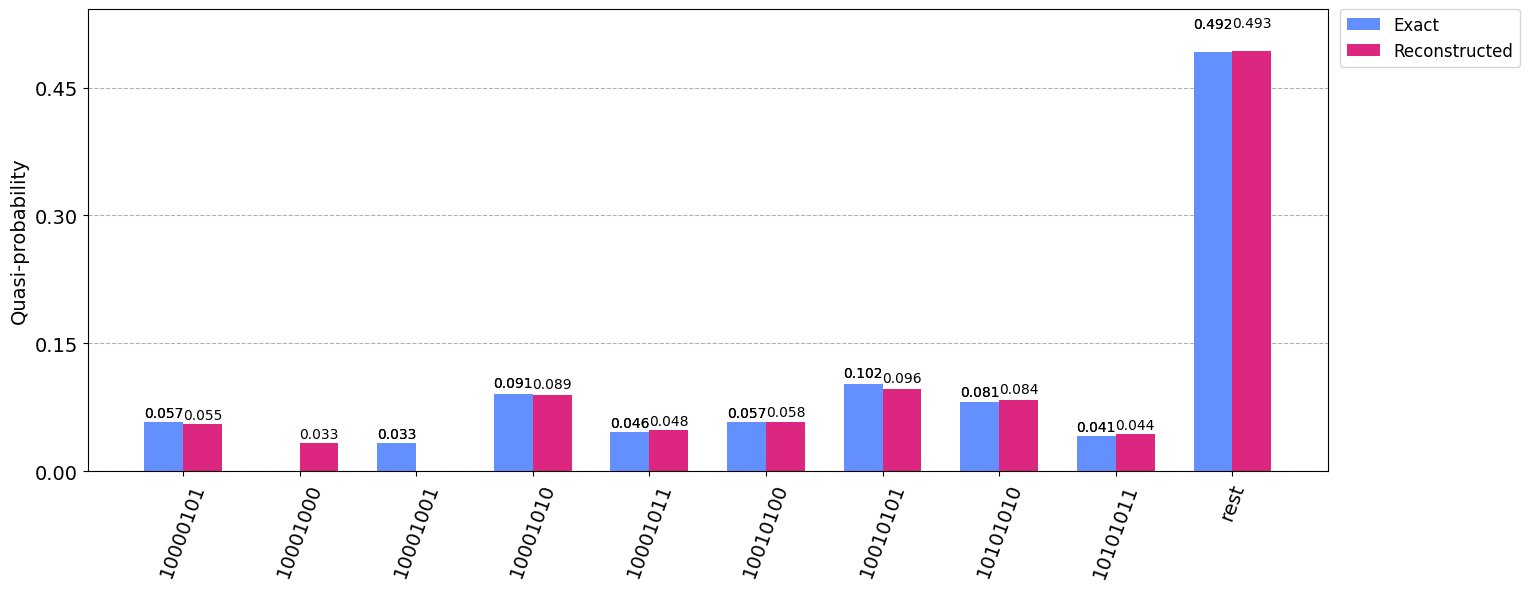

In [27]:
# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

## Entanglement forging overview

Entanglement forging [2] was introduced as a way to reduce the number of qubits necessary to perform quantum simulation of chemical or physical systems. In general, to simulate n orbitals in a chemistry problem, one typically needs 2n qubits. Entanglement Forging makes it possible to represent expectation values of a 2n-qubit wavefunction as sums of multiple expectation values of n-qubit states, embedded in a classical computation, thus doubling the size of the system that can be exactly simulated with a fixed number of qubits.

Furthermore, Entanglement Forging permits the circuits necessary for the n-qubit simulations to be shallower, relaxing requirements on gate error and connectivity, at the cost of increased quantum and classical run times.

The schematic below outlines how the expectation value M of a 2n-qubit wavefunction |ψ>2n with respect to a 2n-qubit Hamiltonian H2n can be decomposed into a sum of expectation values of products of n-qubit wavefunctions with respect to n-qubit operators. These n-qubit expectation values correspond to sub-experiments.

![](forging_info_graphic.png)

1. **Decompose**:
    * Decompose the 2n-qubit ansatz (wavefunction) into many parameterized, n-qubit ansatze
    * Decompose the 2n-qubit observable (Hamiltonian) into many n-qubit observables


2. **Evaluate**:
    * Use the n-qubit expectation values to reconstruct an estimation of the original 2n-qubit expectation value
  
  
3. **Reconstruct** 
    * Use the expectation values to reconstruct an estimation of the expectation value for the 2n-qubit system
  
  
4. **If the expectation value (energy) has not converged, update the ansatze parameters and continue with Step 2**

## Demo: Entanglement forging with `Quantum Serverless`

### Adapting entanglement forging for use with `Quantum Serverless`

[**Quantum Serverless**](https://github.com/Qiskit-Extensions/quantum-serverless) is a platform built to enable distributed computing across a variety of classical and quantum backends.

In this demo, we will show how to configure a ground state workflow with entanglement forging and seamlessly adapt it to run entirely on the cloud using Quantum Serverless.

![title](forging_with_serverless.png)

### Instantiate the `ElectronicStructureProblem`

For this tutorial, we will model a system in which H2O is split on a magnesium surface, as described in Fig. 1(a) from [arXiv:2203.07536](https://arxiv.org/abs/2203.07536). In particular, we'll compute the ground state energy of the reactant in this reaction. Entanglement forging reduces the total number of qubits needed from 4 to 2.

![title](mg_structure.png)

Here we read in the system information, populate an `IntegralDriver` object from `Circuit Knitting Toolbox`, and use that driver to instantiate an `ElectronicStructureProblem` from Qiskit.

In [28]:
from pathlib import Path
import numpy as np
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from circuit_knitting_toolbox.utils import IntegralDriver

system_data = np.load(Path("data") / "reactant_2mo.npz")
num_molecular_orbitals = 2

driver = IntegralDriver(
    hcore=system_data["h1"],
    mo_coeff=system_data["HF_mo_coeff"],
    eri=system_data["Gamma_eri"],
    num_alpha=system_data["na"],
    num_beta=system_data["nb"],
    nuclear_repulsion_energy=system_data["h0"],
)

problem = ElectronicStructureProblem(driver)

### Configure the entanglement forging specific inputs¶
The ansatz for Entanglement Forging consists of a set of input bitstrings and a parameterized circuit. (See the explanatory material for additional background on the method). For this demo, we will use the same bitstrings and ansatz for both the U and V subsystems, and we will use the TwoLocal circuit from Qiskit, along with hop gates.

Hop gate:
     ┌───┐┌───┐     ┌────────────┐     ┌───┐
q_0: ┤ H ├┤ X ├──■──┤ Ry(-1.0*θ) ├──■──┤ H ├
     └───┘└─┬─┘┌─┴─┐├────────────┤┌─┴─┐└───┘
q_1: ───────■──┤ X ├┤ Ry(-1.0*θ) ├┤ X ├─────
               └───┘└────────────┘└───┘     


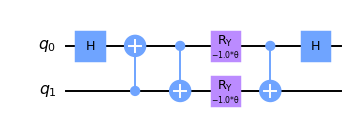

In [24]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

hop_gate = QuantumCircuit(2, name="hop_gate")
hop_gate.h(0)
hop_gate.cx(1, 0)
hop_gate.cx(0, 1)
hop_gate.ry(-theta, 0)
hop_gate.ry(-theta, 1)
hop_gate.cx(0, 1)
hop_gate.h(0)

print(f"Hop gate:\n{hop_gate.draw()}")
hop_gate.draw("mpl", fold=-1, scale=0.7)

In [25]:
from qiskit.circuit.library import TwoLocal
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz

entangler_map = [[0, 1]]
bitstrings_u = [(1, 0), (0, 1)]

circuit_u = TwoLocal(num_molecular_orbitals, [], hop_gate, entangler_map, reps=1)
ansatz = EntanglementForgingAnsatz(
    circuit_u=circuit_u,
    bitstrings_u=bitstrings_u,
)
ansatz.circuit_u.draw("mpl")

NameError: name 'num_molecular_orbitals' is not defined

### Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to Qiskit Runtime Primitives and quantum backends. See the [Qiskit Runtime documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) for more information.  Here, we specify the backend(s) to be used to evaluate the circuits. Backends could be [simulator(s) and/or quantum device(s)](https://quantum-computing.ibm.com/services/resources?tab=systems).

Alternatively, if a Qiskit Runtime Service is not passed, then a local simulator will be used with the [Qiskit Primitives](https://qiskit.org/documentation/apidoc/primitives.html), and the `backend_names` argument will be ignored.

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 2

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 2000})]

### Set up Quantum Serverless

We can use Quantum Serverless to send the entanglement forging routine to a remote compute resource. For this tutorial, we will use our local CPU cores as the compute cluster. See the [Quantum Serverless](https://github.com/Qiskit-Extensions/quantum-serverless) documentation (and below) for more informatin about how to use other clusters.

In [32]:
from quantum_serverless import QuantumServerless

serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

### Create a wrapper function to send to the remote cluster

Use Quantum Serverless to send the `solve_remote` method to a remote cluster.

Here we create a wrapper function for `EntanglementForgingGroundStateSolver` and its `solve` method, and we annotate it with the `@run_qiskit_remote()` decorator from Quantum Serverless. This allows us to call this function from a serverless context and have it sent for remote execution on the specified cluster.

In [33]:
from typing import Optional, Sequence, Tuple, Dict, Union
from qiskit.algorithms.optimizers import Optimizer
from qiskit.result import Result
from quantum_serverless import run_qiskit_remote
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)


@run_qiskit_remote()
def solve_remote(
    problem: ElectronicStructureProblem,
    ansatz_circuit: EntanglementForgingAnsatz,
    optimizer: Optimizer,
    service_args: Optional[Dict] = None,
    backend_names: Optional[Union[str, Sequence[str]]] = None,
    options_dicts: Optional[Union[Dict, Sequence[Dict]]] = None,
    initial_point: Optional[Sequence[float]] = None,
    orbitals_to_reduce: Optional[Sequence[int]] = None,
) -> Result:
    """
    Wrapper function for running entanglement forging VQE on a remote resource.

        Args:
            - problem: A class encoding the problem to be solved
            - ansatz: The ansatz
            - optimizer: Optimizer to use to optimize the ansatz circuit parameters
            - service_args: The arguments for instantiating a QiskitRuntimeService
            - backend_names: List of backend names to use during parallel computation
            - options_dicts: Options to use with backends
            - initial_point: Initial values for ansatz parameters
            - orbitals_to_reduce: List of orbital indices to remove from the problem before
                decomposition.
        Returns:
            - An interpreted EigenstateResult
    """
    service = QiskitRuntimeService(**service_args) if service_args else None

    # Convert options dictionaries into Options objects
    options = None
    if options_dicts:
        if isinstance(options_dicts, Dict):
            options_dicts = [options_dicts]
        options = [Options(**o) for o in options_dicts]

    solver = EntanglementForgingGroundStateSolver(
        ansatz=ansatz,
        service=service,
        optimizer=optimizer,
        backend_names=backend_names,
        options=options,
        initial_point=initial_point,
        orbitals_to_reduce=orbitals_to_reduce,
    )
    result = solver.solve(problem)

    return result

### Run entanglement forging on a remote cluster

Once a user has set up their `ElectronicStructureProblem`, `EntanglementForgingAnsatz`, and other program options, the only thing remaining is call `EntanglementForgingGroundStateSolver.solve`, which we have wrapped in the `solve_remote` function.

We will call the `solve_remote` function within a QuantumServerless context, which means it will be run on the specified cluster. Remember, the default cluster for this demo will use the cores on our local CPU. To specify a new cluster, the `QuantumServerless.set_provider` method should be used.

When the remote function is called, it will return a "future" object, and Python will continue interpreting the next line of code. The `get` function is a blocking command which should be used to retrieve the results of the remote function via the "future" object. The program will not continue past the `get` call until the results of the remote function are returned.

In [34]:
%%capture

from dataclasses import asdict
from qiskit.algorithms.optimizers import COBYLA
from quantum_serverless import get

optimizer = COBYLA()

# QiskitRuntimeService is not serializable, so we must convert it to a dictionary before passing to remote function
service_args = None if service is None else service.active_account()

# The Options class is not serializable, so we must convert it to a dictionary before passing to remote function
options_dicts = [asdict(o) for o in options]

with serverless:
    forging_result_future = solve_remote(
        problem,
        ansatz,
        optimizer,
        service_args=service_args,
        backend_names=backend_names,
        options_dicts=options_dicts,
    )
    results = get(forging_result_future)

### Visualize the results

Visualize the convergence of the estimated ground state energy and the Schmidt coefficients as the ansatz parameters are optimized.

Energy:


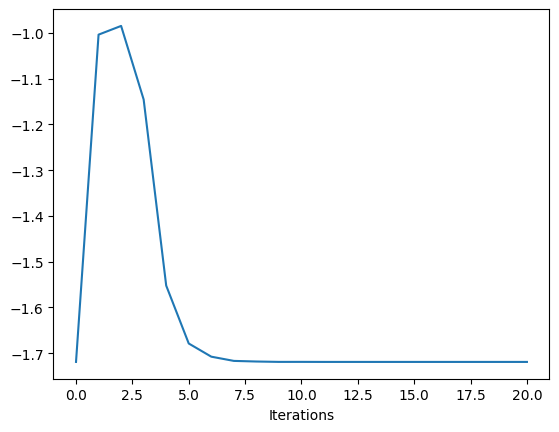

Schmidt Coefficients:


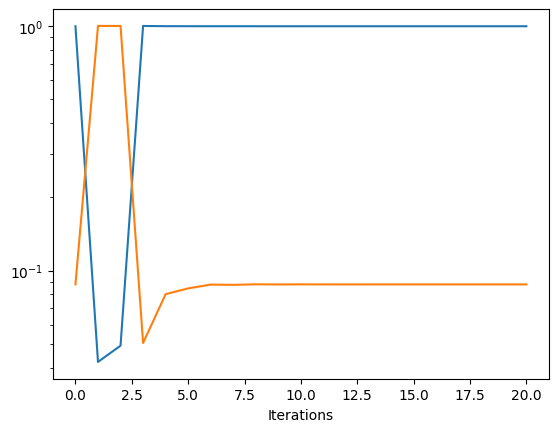

Parameters:


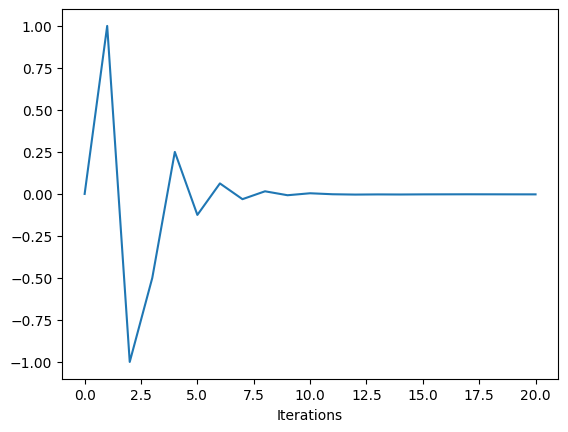

In [35]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

#### References

[1] Wei Tang, Teague Tomesh, Martin Suchara, Jeffrey Larson, Margaret Martonosi, CutQC: Using Small Quantum Computers for Large Quantum Circuit Evaluations, Proceedings of the 26th ACM International Conference on Architectural Support for Programming Languages and Operating Systems. pp. 473 (2021). https://doi.org/10.1145/3445814.3446758

[2] Andrew Eddins, Mario Motta, Tanvi P. Gujarati, Sergey Bravyi, Antonio Mezzacapo, Charles Hadfield, Sarah Sheldon, Doubling the size of quantum simulators by entanglement forging. PRX Quantum 3, 010309 (2022). https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.010309

[3] IBM Research Blog, 'At what cost can we simulate large quantum circuits on small quantum computers?', IBM Research Blog, (2022). https://research.ibm.com/blog/circuit-knitting-with-classical-communication

In [36]:
import qiskit.tools.jupyter

%qiskit_version_table